<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/WCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the Conditional GAN with Wasserstein Loss on the MNIST Fashion Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [2]:
from keras.datasets.fashion_mnist import load_data

def get_fashion_label(batch_size=256):
  (trainX, trainy), (testX, testy) = load_data()
  all_data = np.concatenate([trainX, testX])
  all_data = all_data.astype("float32")
  all_data = (all_data - 127.5) / 127.5
  all_data = np.reshape(all_data, (-1, 28, 28, 1))
  all_labels = np.concatenate([trainy, testy])
  all_labels = all_labels.astype('float32')
  all_labels = tf.one_hot(all_labels,10)
  dataset = tf.data.Dataset.from_tensor_slices((all_data, all_labels))
  dataset = dataset.shuffle(buffer_size=batch_size).prefetch(buffer_size=batch_size).batch(batch_size)
  return dataset

In [3]:
if not os.path.exists('syn_images'):
  folder = os.mkdir('syn_images')

label_names = ["t-shirt", "trousers", "pullover", "dress skirt", "coat", "sandals", "shirt", "sneakers", "bag", "ankle boots"]
dataset = get_fashion_label()
images, image_labels = next(iter(dataset))
print(images.shape)
print(image_labels.shape)
image_labels[:5]

4423680/4422102 [==============================] - 0s 0us/step
(256, 28, 28, 1)
(256, 10)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [7]:
def get_input_dimensions(z_dim, img_shape, n_classes):
  # get the size of the conditional input dimensions
  # from z_dim, the image shape(H*W*C), and number of classes.
  generator_input_dim = z_dim + n_classes
  discriminator_im_chan = img_shape[2] + n_classes
  return generator_input_dim, discriminator_im_chan

gen_input_dim, disc_input_chan = get_input_dimensions(128, (28,28,1), 10)
print(gen_input_dim)
print(disc_input_chan)

138
11


In [8]:
# define the convolutional block
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bias=True, use_bn=False, use_dropout=False, drop_value=0.4):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

# define the upsample block
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
  # the UpSampleing2D repeats and output the same pixel twice
  x = layers.UpSampling2D(up_size)(x)
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  if activation:
    x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x

In [10]:
def get_discriminator_model(img_shape=(28,28,11)):
  img_input = layers.Input(shape=img_shape)
  # Zero pad the input to make the input images size to (32, 32, input_chan).
  x = layers.ZeroPadding2D(padding=(2,2))(img_input)
  x = conv_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False)
  x = conv_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=256, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=True, drop_value=0.3)
  x = conv_block(x=x, filters=512, activation=layers.LeakyReLU(0.2), kernel_size=(5,5), strides=(2,2), use_bias=True, use_bn=False, use_dropout=False, drop_value=0.3)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  # set the inputs and outputs of the model
  d_model = tf.keras.Model(inputs=img_input, outputs=x, name="discriminator")
  return d_model

def get_generator_model(noise_dim=138):
  # input a random noise random_dim + label one-hot
  # reshape into 4*4*256
  noise = layers.Input(shape=(noise_dim,))
  x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Reshape((4, 4, 256))(x)

  # use the UpSampling2D instead of Conv2DTranspose
  x = upsample_block(x=x, filters=128, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  x = upsample_block(x=x, filters=64, activation=layers.LeakyReLU(0.2), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # reshape to 32*32*1
  x = upsample_block(x=x, filters=1, activation=layers.Activation("tanh"), strides=(1,1), use_bias=False, use_bn=True, padding="same")
  # crop to 28*28*1
  x = layers.Cropping2D((2,2))(x)

  # define inputs and outputs
  g_model = tf.keras.Model(inputs=noise, outputs=x, name="generator")
  return g_model

In [11]:
d_model = get_discriminator_model()
g_model = get_generator_model()

In [12]:
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 11)]      0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 11)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        17664     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

In [13]:
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 138)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              565248    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

In [14]:
# define the optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
@tf.function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
# minimize the inverted == maximize
@tf.function
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# define the Gradient Penalty
@tf.function
def gradient_penalty(batch_size, real_images, fake_images, one_hot_labels, discriminator):
  # use an interpolated image to add to the discriminator loss

  # Get the interpolated image
  # alpha = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  epsilon = tf.random.normal(shape=[batch_size,1,1,1], mean=0.0, stddev=1.0)
  diff = fake_images - real_images
  interpolated = real_images + epsilon * diff
  interpolated_and_labels = tf.concat([interpolated, one_hot_labels], axis=3)
  # mixed_images = real_images * epsilon + fake_images * (1.0 - epsilon)

  # compute the gradient of critic(mixed_images)
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated_and_labels)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator(interpolated_and_labels, training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, interpolated_and_labels)
  # 3. Calculate the norm of the gradients.
  # the reduce sum preserve the batch size -- each image has a norm
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  # get the gradient penalty - substract by 1 so that the penalty always least than 1
  gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return gradient_penalty

In [15]:
@tf.function
def train_step(data_batch, Lambda=10.0, d_extra_step=3):
  real_images, image_labels = data_batch
  batch_size = real_images.shape[0]
  # 1. Train the discriminator (critic) and get the discriminator loss for 3 steps
  # 2. Train the generator and get the generator loss for 1 step
  # 3. Calculate the gradient penalty (GP)
  # 4. Multiply this gradient penalty with a constant weight factor Lambda then 
  # sum to the discriminator loss to get the critic loss
  # 6. Return the generator and discriminator losses as a loss dictionary

  # Train the critic
  for i in range(d_extra_step):
    # Sample random points in the latent space
    z_input = tf.random.normal(shape=(batch_size, 128))
    z_input_and_label = tf.concat([z_input,image_labels], axis=1)
    # generated_images = g_model(z_input_and_label)
    image_one_hot_labels = image_labels[:,None, None,:] # batch_size*1*1*10
    image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=28*28) # create all the dimensions in order to reshape
    # batch_size * 28 * 28* 10 -- as the encoded labels
    image_one_hot_labels = tf.reshape(image_one_hot_labels, shape=(batch_size, real_images.shape[1], real_images.shape[2], image_labels.shape[1]))

    with tf.GradientTape() as tape:
      # Decode them to fake images
      generated_images = g_model(z_input_and_label, training=True)
      fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=3)
      fake_logits = d_model(fake_image_and_labels, training=True)
      real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=3)
      real_logits = d_model(real_image_and_labels, training=True)

      # compute the discriminator loss using the fake and real image logit
      d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
      # compute gradient penalty
      gp = gradient_penalty(batch_size=real_images.shape[0], real_images=real_images, fake_images=generated_images, one_hot_labels=image_one_hot_labels, discriminator=d_model)
      # add the gradient penalty to the discriminator loss
      d_loss = d_cost + gp * Lambda
      # compute the gradient based on the total discriminator loss and the discriminator
    d_gradient = tape.gradient(d_loss, d_model.trainable_weights)
    # update the discriminator
    d_optimizer.apply_gradients(zip(d_gradient, d_model.trainable_weights))

  # Train the generator
  z_input = tf.random.normal(shape=(batch_size, 128))
  z_input_and_label = tf.concat([z_input,image_labels], axis=1)
  with tf.GradientTape() as tape:
    generated_images = g_model(z_input_and_label, training=True)
    # Get the discriminator logits for fake images
    gen_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=3)
    gen_img_logits = d_model(gen_image_and_labels, training=True)
    # Calculate the generator loss
    g_loss = generator_loss(fake_img=gen_img_logits)
  # get the gradient of the generator loss
  g_gradient = tape.gradient(g_loss, g_model.trainable_weights)
  # update the generator
  g_optimizer.apply_gradients(zip(g_gradient, g_model.trainable_weights))

  return d_loss, g_loss, generated_images

In [16]:
epochs = 30  # In practice you need at least 20 epochs to generate nice digits.
save_dir = './syn_images'
history = {}
history['d_loss'] = []
history['g_loss'] = []
# total_step = total_step
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    d_loss_list = []
    g_loss_list = []


    for step, data_batch in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(data_batch)
        d_loss_list.append(d_loss)
        g_loss_list.append(g_loss)

        # Logging.
        if step % 100 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                (generated_images[0] * 255.0), scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))
    
    print("------End of epoch: {epoch}------")
    mean_d_loss = np.array(d_loss_list).mean()
    mean_g_loss = np.array(g_loss_list).mean()
    history['d_loss'].append(mean_d_loss)
    history['g_loss'].append(mean_g_loss)
    print("discriminator loss at epoch %d: %.2f" % (epoch, mean_d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, mean_g_loss))


Start epoch 0
discriminator loss at step 0: 6.53
adversarial loss at step 0: -0.00
discriminator loss at step 100: -6.40
adversarial loss at step 100: -17.65
discriminator loss at step 200: -6.62
adversarial loss at step 200: -16.89
------End of epoch: {epoch}------
discriminator loss at epoch 0: -6.88
adversarial loss at epoch 0: -16.37

Start epoch 1
discriminator loss at step 0: -6.56
adversarial loss at step 0: -14.98
discriminator loss at step 100: -6.48
adversarial loss at step 100: -6.77
discriminator loss at step 200: -5.77
adversarial loss at step 200: -1.05
------End of epoch: {epoch}------
discriminator loss at epoch 1: -6.26
adversarial loss at epoch 1: -4.78

Start epoch 2
discriminator loss at step 0: -4.99
adversarial loss at step 0: 3.40
discriminator loss at step 100: -4.92
adversarial loss at step 100: 1.13
discriminator loss at step 200: -4.16
adversarial loss at step 200: 0.81
------End of epoch: {epoch}------
discriminator loss at epoch 2: -4.81
adversarial loss a

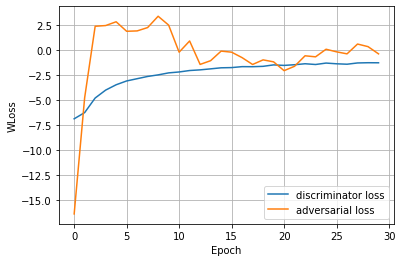

In [17]:
def plot_loss(history):
  plt.plot(history['d_loss'], label='discriminator loss')
  plt.plot(history['g_loss'], label='adversarial loss')
  # plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('WLoss')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [18]:
def gen_samples(n, g_model=g_model):
  sample_labels = np.random.randint(low=0, high=9, size=n*n)
  sample_labels = tf.convert_to_tensor(sample_labels)
  one_hot_labels = tf.one_hot(sample_labels, 10)
  z_input = tf.random.normal(shape=(n*n, 128))
  z_input_and_label = tf.concat([z_input,one_hot_labels], axis=1)
  gen_images = g_model(z_input_and_label)
  return gen_images, one_hot_labels

In [19]:
gen_images, labels = gen_samples(5)

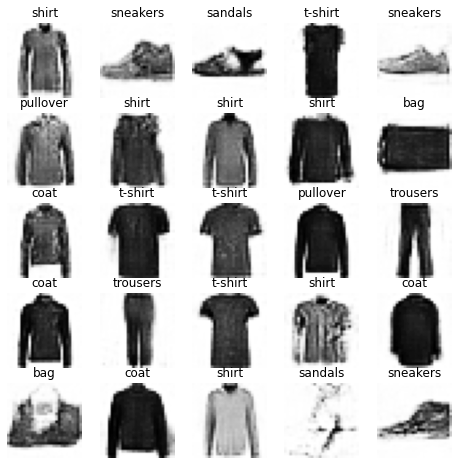

In [20]:
def show_samples(n, images, labels, label_names):
  plt.figure(figsize=(8,8))
  label_idx = np.argmax(labels, axis=1)
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis(False)
    plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.title(label_names[label_idx[i]])
  plt.show()

label_names = ['t-shirt','trousers','pullover','dress skirt','coat','sandals','shirt','sneakers','bag','ankle boots']
show_samples(5, gen_images, labels, label_names)